# Tokenize full book

In [16]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/home/ubuntu/miniconda3/envs/transformers-twiker/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
with open("data_files/full.txt", 'r') as fs:
    book_text = fs.read()

In [18]:
import numpy as np

book_tokens = np.array(tokenizer.tokenize(book_text))
book_ids = np.array(tokenizer.convert_tokens_to_ids(book_tokens))

In [19]:
# unique
book_ids_unique, index, counts = np.unique(book_ids, return_index=True, return_counts=True)
book_tokens_unique = book_tokens[index]

print("Total", len(book_ids))
print("Unique", len(book_ids_unique))

Total 1609632
Unique 20524


# For linguistic analysis, we need to add these properties to `book_ids_unique`:

* Counts of appearance: already found above
* Class as one of follows: noun, verb, adjective, ..., punctuation, affix, letter, num, other

In [20]:
def find_non_ascii_characters(input_string):
    non_ascii_characters = [char for char in input_string if ord(char) > 127]
    return np.unique(non_ascii_characters)

# Example usage
non_ascii_characters = find_non_ascii_characters(book_text)
print("Non-ASCII characters:", non_ascii_characters)

Non-ASCII characters: ['£' '¦' '«' '°' '»' 'é' 'ü' '˜' '–' '—' '‘' '’' '“' '”' '•' '…']


In [21]:
import string
import spacy, nltk
from nltk.corpus import words

# punctuation
def is_punctuation(char):
    return char in string.punctuation or char in non_ascii_characters

# pos of word
nlp = spacy.load("en_core_web_sm")
def get_pos(word):
    doc = nlp(word)
    for token in doc:
        return token.pos_

# common word
nltk.download('words')
common_words = set(words.words())
def common_word(word):
    return word.lower() in common_words

[nltk_data] Downloading package words to /home/ubuntu/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [22]:
classes = []

for tok in book_tokens_unique:
    if len(tok) == 1:
        if is_punctuation(tok):
            classes.append("punctuation")
        elif tok.isalpha():
            classes.append("letter")
        elif tok.isdigit():
            classes.append("num")
        else:
            classes.append("other")
        continue
    
    if tok[0] != "Ġ":
        classes.append("affix")
        continue

    tok = tok[1:]
    if len(tok) == 1:
        if is_punctuation(tok):
            classes.append("punctuation")
            continue
        if tok.isalpha() and tok not in ["I", "a", "A"]:  # here we check single-char words
            classes.append("letter")
            continue
        elif tok.isdigit():
            classes.append("num")
            continue
    if not common_word(tok):
        classes.append("affix")
        continue
    classes.append(get_pos(tok).lower())
classes = np.array(classes)

In [23]:
# let's take a look
classes_unique = np.unique(classes)

for cls in classes_unique:
    print(cls, len(np.where(classes == cls)[0]))
    print(book_tokens_unique[classes == cls][:100])
    print()

adj 1271
['Ġpro' 'Ġother' 'Ġnew' 'Ġmany' 'Ġsuch' 'Ġown' 'Ġgood' 'Ġlast' 'ĠNew'
 'Ġsame' 'Ġhigh' 'ĠPro' 'Ġgreat' 'Ġreal' 'Ġpublic' 'Ġfew' 'Ġdifferent'
 'Ġbig' 'Ġbest' 'Ġlittle' 'Ġtri' 'Ġfull' 'Ġtop' 'Ġmain' 'Ġsmall'
 'Ġcurrent' 'Ġold' 'Ġfree' 'Ġable' 'Ġleast' 'Ġlarge' 'Ġimportant' 'Ġclear'
 'Ġlight' 'Ġmajor' 'Ġavailable' 'Ġcertain' 'Ġpossible' 'Ġproper' 'Ġshort'
 'Ġseveral' 'Ġcomplete' 'Ġyoung' 'Ġlow' 'Ġant' 'Ġstrong' 'Ġsocial'
 'Ġparticular' 'Ġlocal' 'Ġpolitical' 'Ġformer' 'Ġkey' 'Ġspecial' 'Ġblack'
 'Ġsingle' 'Ġquick' 'Ġtrue' 'Ġbad' 'Ġsimilar' 'Ġentire' 'Ġspecific'
 'Ġprevious' 'Ġwhole' 'Ġcommon' 'Ġdue' 'Ġnational' 'Ġrecent' 'Ġgeneral'
 'ĠRed' 'Ġmass' 'ĠNational' 'Ġthird' 'Ġsignificant' 'Ġdifficult' 'Ġhigher'
 'Ġfinal' 'ĠSouth' 'Ġeasy' 'Ġpersonal' 'ĠBlack' 'ĠWhite' 'Ġdead' 'Ġwrong'
 'Ġoriginal' 'Ġprim' 'Ġsoft' 'Ġserious' 'Ġlegal' 'Ġill' 'Ġaverage'
 'Ġperfect' 'Ġsimple' 'Ġprivate' 'Ġworth' 'Ġselect' 'Ġpopular' 'Ġvarious'
 'Ġprofess' 'Ġhot' 'Ġcivil']

adp 104
['Ġof' 'Ġin' 'Ġon' 'Ġfor' '

In [24]:
# this looks reasonable, but classes are too many
# so we select the most meaningful ones
super_classes = ["adj", "adp", "adv", "aux", "verb", "cconj", "noun", "pron", "sconj", "verb"]

# show some stats
class_counts_unique = []
class_counts_total = []

for cls in super_classes:
    idx = np.where(classes == cls)[0]
    class_counts_unique.append(len(idx))
    class_counts_total.append(counts[idx].sum())

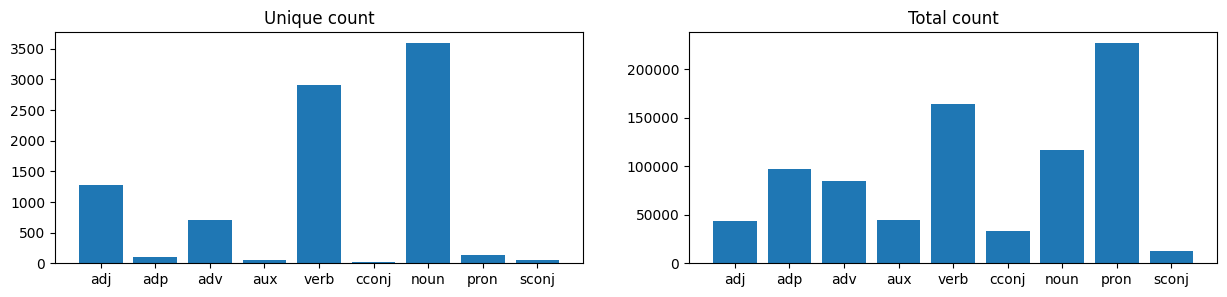

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].bar(super_classes, class_counts_unique)
ax[0].set_title("Unique count")
ax[1].bar(super_classes, class_counts_total)
ax[1].set_title("Total count")
plt.show()

# Summary

In [26]:
# use `book_ids_unique` to retrieve kernels from trained model
print(len(book_ids_unique), book_ids_unique)

# use `book_tokens_unique` to see word
print(len(book_tokens_unique), book_tokens_unique)

# use `counts` to filter out low-frequency tokens
print(len(counts), counts)

# use `classes` to find the type of words
print(len(classes), classes)

20524 [    0     1     6 ... 50244 50248 50255]
20524 ['!' '"' "'" ... 'Ġdesolate' 'âĢ¦."' 'Ġgazed']
20524 [6337   12 2675 ...    1    2   66]
20524 ['punctuation' 'punctuation' 'punctuation' ... 'verb' 'affix' 'affix']


# Analysis

In [27]:
import torch
from transformers import GPT2LMHeadModel
import json

In [28]:
# Specify the path to the checkpoint file
checkpoint_path = '../../results/gpt2/potter/train_twiker'

# Specify key or value
analyze_value = True

In [29]:
# load config
with open(f'{checkpoint_path}/config.json', 'r') as file:
    config = json.load(file)

# Load the model with the checkpoint
model = GPT2LMHeadModel.from_pretrained(checkpoint_path)

# weight
embedding_weights = model.transformer.twiker_model.embedding.weight.detach()

# reshape
n_head = 1 if config["twiker_head_invariant"] else config["n_head"]
n_layer = 1 if config["twiker_layer_invariant"] or config["twiker_only_first_layer"] else config["n_layer"]
embedding_weights = embedding_weights.reshape(-1, n_layer, 2, n_head, config["twiker_kernel_size"])

# soft max
embedding_weights = torch.softmax(embedding_weights / 0.4, dim=-1)

# mean over head and layer
embedding_weights = embedding_weights.mean(dim=1).mean(dim=2)

# extract for book
embedding_weights = embedding_weights[book_ids_unique]

# extract for value
wv = embedding_weights[:, 1, :] if analyze_value else embedding_weights[:, 0, :]
print(wv.shape)

torch.Size([20524, 3])


In [30]:
# compute distance
t010 = torch.zeros(config["twiker_kernel_size"])
t010[config["twiker_kernel_size"] // 2] = 1.
dist010 = torch.norm(wv - t010, dim=1)

### Filter by `counts`

In [31]:
filter = counts >= 5

book_ids_counts = book_ids_unique[filter]
book_tokens_counts = book_tokens_unique[filter]
classes_counts = classes[filter]
dist010_counts = dist010[filter]

print(len(dist010_counts))

10827


In [32]:
# statistics on all

argsort = torch.argsort(dist010_counts, descending=True)
book_tokens_counts[argsort[:100]]

array(['Ġ', 'Ġvery', 'âĢ', ',', 'Ġa', 'Ġof', 'ĠâĢ', 'Ġwas', 'Ġand', '.',
       'Ġto', 'Ġhis', 'Ġthe', 'ĠProfessor', 'Who', 'Ġyou', 'Ġwith',
       'Ġthey', 'ĠThe', 'ľ', 'ĠHogwarts', 'Ġsaid', 'Ġhorrible', 'Ġeyes',
       "'s", 'ĠRon', '?', '-', 'ĠWeasley', 'Ġcould', 'ĠHermione',
       'Ġlarge', 'ĠFl', 'Ŀ', 'ĠI', 'Ġempty', 'Ġthat', '!', 'Ġblack',
       'ĠHarry', 'Ġhad', 'Ġgl', 'Ġhe', 'Ġalmost', 'Ġthick', 'Ġloud',
       'ĠHuff', 'Ġit', 'ĠMalfoy', 'ĠSnape', 'Ġfor', 'rid', 'Ġenormous',
       'Ġjust', 'Ġdark', 's', 'Ġgot', 'Ġnasty', 'Ġalready', 'Ġnearly',
       'uggle', 'Ġold', 'Ļ', 'Ġstill', 'It', 'Ġstomach', 'I', 'Ġ-',
       'Ġfunny', 'Ġown', 'Ġan', 'Ġslowly', 'Ġodd', 'Ġmarble', 'Ġtheir',
       'ĠHe', 'âĢ¦', 'ed', 'itch', 'Ġfeet', 'Ġwhen', 'ĠD', 'Ġgreat',
       'Ġsuddenly', 'in', 'Ġflying', 'Ġsudden', 'Ġquite', 'Ġhim', 'Harry',
       'Ġon', 'Ġsmall', "'t", 'ĠF', 'Ġsnake', 'ĺ', 'ĠPercy', 'auldron',
       'anks', 'Ġturned'], dtype='<U18')

### Filter by `class`

In [33]:
# statistics on role

cls_mean = []
for cls in super_classes:
    filter = (classes_counts == cls)
    book_ids_cls = book_ids_counts[filter]
    book_tokens_cls = book_tokens_counts[filter]
    dist010_cls = dist010_counts[filter]
    mean = dist010_cls.mean()
    cls_mean.append(mean)

<BarContainer object of 10 artists>

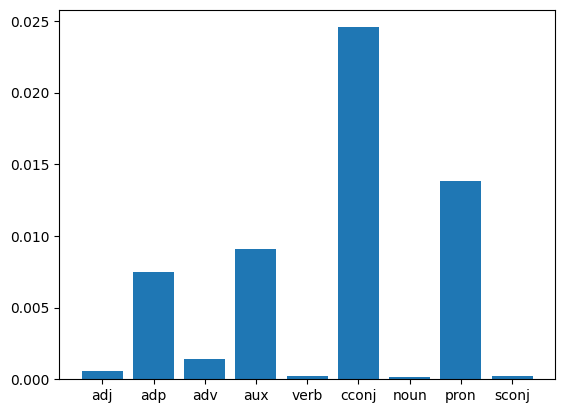

In [34]:
plt.bar(super_classes, cls_mean)
